In [1]:
%%writefile conf/config.yaml
defaults :
  - modulus_default
  - arch:
      - fully_connected
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: res_norm
  - _self_

save_filetypes : "vtk,npz"

scheduler:
  decay_rate: 0.95
  decay_steps: 1000

training:
  rec_results_freq: 1000
  max_steps: 5000

batch_size:
  IC: 124
  interior: 1024
    
debug: False   
    

Overwriting conf/config.yaml


In [2]:
%%writefile fhnatvdd.py
import torch
import numpy as np

import modulus
from modulus.models.deeponet import DeepONetArch
from modulus.domain.constraint.continuous import DeepONetConstraint


from sympy import Symbol, Eq
from sympy import Symbol, Function, Number
from modulus.eq.pde import PDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import modulus
from modulus.hydra import instantiate_arch, ModulusConfig
from modulus.solver import Solver
from modulus.domain import Domain
from modulus.geometry.primitives_1d import Point1D
from modulus.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseBoundaryConstraint,
)
from modulus.domain.validator import PointwiseValidator
from modulus.key import Key
from modulus.node import Node
from modulus.eq.pde import PDE
from modulus.utils.io import (
    csv_to_dict,
    ValidatorPlotter,
    InferencerPlotter,
)
from modulus.dataset import *
from modulus.domain.constraint import SupervisedGridConstraint
HYDRA_FULL_ERROR=1

a=0.001
def generateExactSolution(t,dt,x0,rate):
    
    n2=int(t/dt)
    n = int(t/(dt*rate))
    Sol=np.zeros(n)
    Sol[0]=x0
    Sol2=np.zeros(n2)
    Sol2[0]=x0
    T=0
    k=0
    while(k<n2-1):
        x=Sol2[k]
        Sol2[k+1]=x*(x-0.5)*(1-x)*dt +  x
        if ((k+1)%rate == 0):
            T=T+1
            Sol[T] = Sol2[k+1]         
        k=k+1
    return Sol


class SpringMass(PDE):
    name = "SpringMass"

    def __init__(self):

      
     

        t = Symbol("t")
        input_variables = {"t": t}

        x1 = Function("x1")(*input_variables)



        self.equations = {}
        self.equations["ode_x1"] = x1*(1-x1)*(x1-0.5) -x1.diff(t)
                                    
                                    
        
@modulus.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig) -> None:
    x0=0.6
    c1=1/x0 -1
    t_max = 10.0
    
     
    t_symbol = Symbol("t")
    x = Symbol("x")
   
    
    # make list of nodes to unroll graph on
    sm = SpringMass()
    sm_net = instantiate_arch(
        input_keys=[Key("t",scale=(0,t_max))],
        output_keys=[Key("x1",scale=(0,1))],
        cfg=cfg.arch.fully_connected,
    )
    nodes = sm.make_nodes() + [
        sm_net.make_node(name="spring_mass_network")
    ]

   
    # add constraints to solver
    # make geometry
    geo = Point1D(0)
    print(geo)
  
    time_range = {t_symbol: (0, t_max)}

    # make domain
    domain = Domain()

    # initial conditions
    IC = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"x1": x0},
        batch_size=cfg.batch_size.IC,
        lambda_weighting={
            "x1": 1.0,


        },
        parameterization={t_symbol: 0},
    )
   # domain.add_constraint(IC, name="IC")

    
    
    # solve over given time period
    interior = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"ode_x1": 0.0},
        batch_size=cfg.batch_size.interior,
        parameterization=time_range,
        
    )
   # domain.add_constraint(interior, "interior")

    
    ##Data driven constraing
    rate = 100
    deltaT = 0.01
    t = np.linspace(0, t_max, int((t_max/(deltaT)) /rate) )
    t = np.expand_dims(t, axis=-1)
    t = np.expand_dims(t, axis=-1)
    t = np.expand_dims(t, axis=-1)
    print(np.shape(t))
    Sol=generateExactSolution(t_max,deltaT,x0,rate)
    Sol = np.expand_dims(Sol, axis=-1)
    Sol = np.expand_dims(Sol, axis=-1)
    Sol = np.expand_dims(Sol, axis=-1)
    print(np.shape(t),"training set")
    invar_numpy = {"t": t}
    outvar_numpy = {
        "x1": Sol
    }
    trainset=DictGridDataset(invar_numpy,outvar_numpy)
    
    data = DeepONetConstraint.from_numpy(
        nodes=nodes,
        invar={"t":t},
        outvar={"x1":Sol},
        batch_size=10,
    )
    domain.add_constraint(data, "data")
    
    
    
    
    
    tmax=10
    # add validation data
    rate = 10
    deltaT = 0.01
    t = np.linspace(0, t_max, int((t_max/(deltaT)) /rate) )
    t = np.expand_dims(t, axis=-1)
    Sol=generateExactSolution(t_max,deltaT,x0,rate)
    invar_numpy = {"t": t}
    plt.plot(Sol,"o")
    plt.show()
    print(np.shape(t),"val set")


    outvar_numpy = {
        "x1": Sol
    }
    validator = PointwiseValidator(
        nodes=nodes, invar=invar_numpy, true_outvar=outvar_numpy, batch_size=124,
    )
    domain.add_validator(validator)

    # make solver
    slv = Solver(cfg, domain)

    # start solver
    slv.solve()


if __name__ == "__main__":
    run()


Overwriting fhnatvdd.py


In [3]:
!rm -r outputs/fhnatvdd || true ##se não limpar o output ele aproveita o treinamento, mesmo se mudar o modelo
!python fhnatvdd.py

[04:25:41] - JIT using the NVFuser TorchScript backend
[04:25:41] - JitManager: {'_enabled': True, '_arch_mode': <JitArchMode.ONLY_ACTIVATION: 1>, '_use_nvfuser': True, '_autograd_nodes': False}
[04:25:41] - GraphManager: {'_func_arch': False, '_debug': False, '_func_arch_allow_partial_hessian': True}
(10, 1, 1, 1)
(10, 1, 1, 1) training set
Figure(640x480)
(100, 1) val set
[04:25:43] - Installed PyTorch version 1.13.1+cu117 is not TorchScript supported in Modulus. Version 1.13.0a0+d321be6 is officially supported.
[04:25:43] - attempting to restore from: outputs/fhnatvdd
[04:25:43] - optimizer checkpoint not found
[04:25:43] - model spring_mass_network.0.pth not found
[04:25:44] - [step:          0] record constraint batch time:  8.980e-03s
[04:25:44] - [step:          0] record validators time:  4.215e-03s
[04:25:44] - [step:          0] saved checkpoint to outputs/fhnatvdd
[04:25:44] - [step:          0] loss:  6.199e+00
[04:25:47] - Attempting cuda graph building, this may take a bi

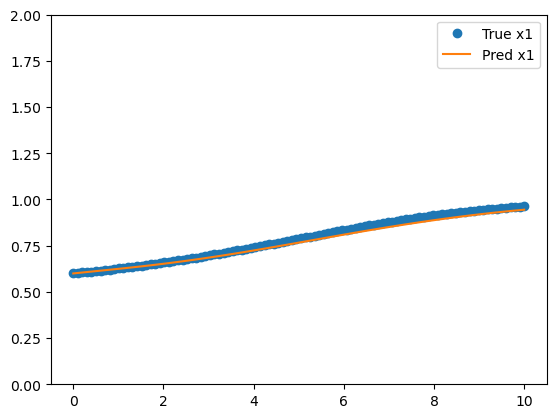

In [4]:
import numpy as np
import matplotlib.pyplot as plt

base_dir = "outputs/fhnatvdd/validators/"

# plot in 1d
data = np.load(base_dir + "validator.npz", allow_pickle=True)
data = np.atleast_1d(data.f.arr_0)[0]

plt.plot(data["t"], data["true_x1"],"o", label="True x1")

plt.plot(data["t"], data["pred_x1"], label="Pred x1")

plt.ylim(0,2)
plt.legend()
plt.savefig("comparison.png")

